In [ ]:
!pip install transformers
!pip install sastrawi
!pip install -q datasets
!pip install -q torch torchvision torchaudio

# Install NLTK data
import nltk
nltk.download('punkt')
nltk.download('stopwords')

print("✓ Semua dependencies berhasil diinstall!")

✓ Semua dependencies berhasil diinstall!


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import pandas as pd
import numpy as np
import re
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, Bidirectional, Input, Concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

# NLP Libraries
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

print("✓ Semua library berhasil diimport!")

✓ Semua library berhasil diimport!


In [ ]:
from google.colab import files
import os

if not os.path.exists('/content/Data_f_h.xlsx'):
    print("File data2.csv tidak ditemukan. Silakan upload file:")
    uploaded = files.upload()

# Load dataset
df = pd.read_excel('/content/Data_f_h.xlsx')

print("=== INFORMASI DATASET ===")
print(f"Jumlah data: {len(df)}")
print(f"Kolom: {list(df.columns)}")
print(f"\nSample data:")
print(df.head())

print(f"\nInfo dataset:")
print(df.info())

print(f"\nMissing values:")
print(df.isnull().sum())

File data2.csv tidak ditemukan. Silakan upload file:


Saving Data_f_h.xlsx to Data_f_h.xlsx
=== INFORMASI DATASET ===
Jumlah data: 659
Kolom: ['Content', 'Class']

Sample data:
                                             Content     Class
0  Bek Madura United, Ruxi ikut bersuara terhadap...  non-hoax
1  Timnas Irak akan bersaing dengan Arab Saudi da...  non-hoax
2  Laga semifinal Piala AFF U-23 2025 tak mudah b...  non-hoax
3  Enam negara akan bertarung di ronde keempat Ku...  non-hoax
4  Timnas Indonesia U-23 mengantongi rekor pertem...  non-hoax

Info dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 659 entries, 0 to 658
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Content  659 non-null    object
 1   Class    659 non-null    object
dtypes: object(2)
memory usage: 10.4+ KB
None

Missing values:
Content    0
Class      0
dtype: int64


Kolom yang tersedia: ['Content', 'Class']
Text column detected: Content
Label column detected: Class

Menggunakan:
Text column: Content
Label column: Class

=== DISTRIBUSI LABEL ===
Class
non-hoax    413
hoax        246
Name: count, dtype: int64


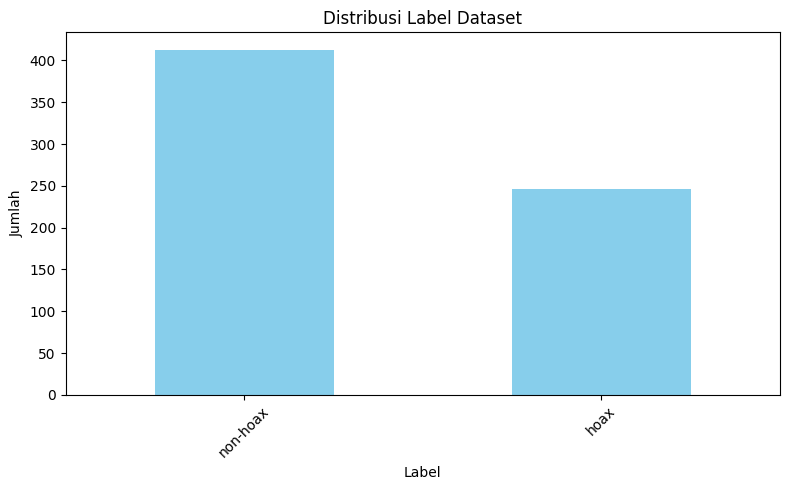


=== STATISTIK PANJANG TEKS ===
Rata-rata: 1230.44 karakter
Median: 1054.00 karakter
Min: 37 karakter
Max: 4396 karakter


In [ ]:
print("Kolom yang tersedia:", df.columns.tolist())

# Set manual kolom text dan label
text_column = 'Content'
label_column = 'Class'

print(f"Text column detected: {text_column}")
print(f"Label column detected: {label_column}")

print(f"\nMenggunakan:")
print(f"Text column: {text_column}")
print(f"Label column: {label_column}")

# Analisis distribusi label
print(f"\n=== DISTRIBUSI LABEL ===")
label_counts = df[label_column].value_counts()
print(label_counts)

# Visualisasi distribusi
plt.figure(figsize=(8, 5))
label_counts.plot(kind='bar', color='skyblue')
plt.title('Distribusi Label Dataset')
plt.xlabel('Label')
plt.ylabel('Jumlah')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Statistik panjang teks
df['text_length'] = df[text_column].astype(str).apply(len)
print(f"\n=== STATISTIK PANJANG TEKS ===")
print(f"Rata-rata: {df['text_length'].mean():.2f} karakter")
print(f"Median: {df['text_length'].median():.2f} karakter")
print(f"Min: {df['text_length'].min()} karakter")
print(f"Max: {df['text_length'].max()} karakter")

In [ ]:
class HoaxClassifier:
    def __init__(self):
        self.tokenizer = None
        self.model = None
        self.ner_pipeline = None
        self.stemmer = StemmerFactory().create_stemmer()
        self.stopwords_id = set(stopwords.words('indonesian'))
        self.label_encoder = LabelEncoder()
        self.max_sequence_length = 500
        self.max_vocab_size = 10000
        self.ner_feature_dim = 20

        # Load Indonesian NER model
        self.load_ner_model()

    def load_ner_model(self):
        """Load pre-trained Indonesian NER model"""
        try:
            print("Loading Indonesian NER model...")
            # Menggunakan IndoBERT-NER dari Hugging Face
            model_name = "cahya/bert-base-indonesian-NER"
            self.ner_tokenizer = AutoTokenizer.from_pretrained(model_name)
            self.ner_model = AutoModelForTokenClassification.from_pretrained(model_name)
            self.ner_pipeline = pipeline("ner",
                                        model=self.ner_model,
                                        tokenizer=self.ner_tokenizer,
                                        aggregation_strategy="simple")
            print("✓ Indonesian NER model loaded successfully")
        except Exception as e:
            print(f"⚠ Error loading NER model: {e}")
            print("Menggunakan fallback method untuk NER...")
            self.ner_pipeline = None

    def clean_text(self, text):
        """Pembersihan teks bahasa Indonesia"""
        if pd.isna(text):
            return ""

        # Konversi ke lowercase
        text = str(text).lower()

        # Hapus URL, email, dan mention
        text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
        text = re.sub(r'\S+@\S+', '', text)
        text = re.sub(r'@\w+', '', text)

        # Hapus karakter khusus, tapi pertahankan spasi
        text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)

        # Hapus angka yang berdiri sendiri
        text = re.sub(r'\b\d+\b', '', text)

        # Hapus spasi berlebih
        text = re.sub(r'\s+', ' ', text).strip()

        return text

    def extract_ner_features(self, text):
        """Ekstrak fitur Named Entity Recognition"""
        if not self.ner_pipeline:
            # Fallback: hitung kata dengan huruf kapital sebagai entitas sederhana
            entities = re.findall(r'\b[A-Z][a-z]+(?:\s+[A-Z][a-z]+)*\b', text)
            return {
                'person_count': len([e for e in entities if len(e.split()) <= 2]),
                'org_count': len([e for e in entities if len(e.split()) > 2]),
                'loc_count': 0,
                'misc_count': 0,
                'total_entities': len(entities),
                'entity_density': len(entities)/len(text.split()) if text.split() else 0
            }

        try:
            # Gunakan model NER Indonesian
            entities = self.ner_pipeline(text)

            # Hitung entitas berdasarkan kategori
            entity_counts = {
                'B-PER': 0, 'I-PER': 0,  # Person
                'B-ORG': 0, 'I-ORG': 0,  # Organization
                'B-LOC': 0, 'I-LOC': 0,  # Location
                'B-MISC': 0, 'I-MISC': 0  # Miscellaneous
            }

            for entity in entities:
                label = entity['entity_group'] if 'entity_group' in entity else entity.get('label', 'O')
                if label in entity_counts:
                    entity_counts[label] += 1

            # Gabungkan B- dan I- tags
            person_count = entity_counts['B-PER'] + entity_counts['I-PER']
            org_count = entity_counts['B-ORG'] + entity_counts['I-ORG']
            loc_count = entity_counts['B-LOC'] + entity_counts['I-LOC']
            misc_count = entity_counts['B-MISC'] + entity_counts['I-MISC']
            total_entities = person_count + org_count + loc_count + misc_count

            word_count = len(text.split())
            entity_density = total_entities / word_count if word_count > 0 else 0

            return {
                'person_count': person_count,
                'org_count': org_count,
                'loc_count': loc_count,
                'misc_count': misc_count,
                'total_entities': total_entities,
                'entity_density': entity_density
            }

        except Exception as e:
            print(f"Error in NER extraction: {e}")
            return {
                'person_count': 0,
                'org_count': 0,
                'loc_count': 0,
                'misc_count': 0,
                'total_entities': 0,
                'entity_density': 0
            }

    def preprocess_text(self, text):
        """Preprocessing teks dengan stemming dan stopword removal"""
        if not text:
            return ""

        # Tokenisasi
        tokens = word_tokenize(text)

        # Hapus stopwords dan stem
        processed_tokens = []
        for token in tokens:
            if token not in self.stopwords_id and len(token) > 2:
                # Stemming dengan Sastrawi
                stemmed = self.stemmer.stem(token)
                processed_tokens.append(stemmed)

        return ' '.join(processed_tokens)

print("✓ HoaxClassifier class (part 1) defined successfully!")

✓ HoaxClassifier class (part 1) defined successfully!


In [ ]:
class HoaxClassifier:
    def __init__(self, max_vocab_size=10000, max_sequence_length=500, embedding_dim=128):
        self.max_vocab_size = max_vocab_size
        self.max_sequence_length = max_sequence_length
        self.embedding_dim = embedding_dim
        self.tokenizer = None
        self.model = None
        self.label_encoder = LabelEncoder()

        # Initialize Indonesian NER model
        self.ner_model = None
        self.ner_tokenizer = None
        self._load_indonesian_ner()

    def _load_indonesian_ner(self):
        """Load Indonesian BERT NER model"""
        try:
            print("Loading Indonesian NER model...")
            from transformers import AutoTokenizer, AutoModelForTokenClassification
            import torch

            model_name = "cahya/bert-base-indonesian-NER"
            self.ner_tokenizer = AutoTokenizer.from_pretrained(model_name)
            self.ner_model = AutoModelForTokenClassification.from_pretrained(model_name)

            # Set device
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            self.ner_model.to(self.device)
            self.ner_model.eval()

            print(f"Device set to use {self.device}")
            print("✓ Indonesian NER model loaded successfully")

        except Exception as e:
            print(f"Error loading Indonesian NER model: {e}")
            self.ner_model = None
            self.ner_tokenizer = None

    def clean_text(self, text):
        """Membersihkan teks"""
        if pd.isna(text):
            return ""

        text = str(text).lower()
        text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
        text = re.sub(r'[^a-zA-Z\s]', '', text)     # Remove special characters
        text = re.sub(r'\s+', ' ', text).strip()    # Remove extra whitespace
        return text

    def preprocess_text(self, text):
        """Preprocessing tambahan untuk teks"""
        return text  # For now, just return cleaned text

    def extract_ner_features(self, text):
        """Ekstraksi fitur Named Entity Recognition menggunakan Indonesian BERT"""
        try:
            if self.ner_model is None or self.ner_tokenizer is None:
                # Fallback to default values if NER model not loaded
                return {
                    'person_count': 0,
                    'org_count': 0,
                    'loc_count': 0,
                    'misc_count': 0,
                    'total_entities': 0,
                    'entity_density': 0
                }

            import torch

            # Tokenize with proper truncation and padding
            inputs = self.ner_tokenizer(
                text,
                return_tensors="pt",
                truncation=True,
                max_length=512,
                padding=True,
                return_offsets_mapping=False
            )

            # Move to device
            inputs = {k: v.to(self.device) for k, v in inputs.items()}

            # Get predictions
            with torch.no_grad():
                outputs = self.ner_model(**inputs)
                predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
                predicted_token_class_ids = predictions.argmax(dim=-1)

            # Convert predictions to labels
            tokens = self.ner_tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
            predicted_tokens_classes = [self.ner_model.config.id2label[t.item()]
                                      for t in predicted_token_class_ids[0]]

            # Count entities by type (Indonesian NER labels)
            person_count = sum(1 for label in predicted_tokens_classes if 'PER' in label and label.startswith('B-'))
            org_count = sum(1 for label in predicted_tokens_classes if 'ORG' in label and label.startswith('B-'))
            loc_count = sum(1 for label in predicted_tokens_classes if 'LOC' in label and label.startswith('B-'))
            misc_count = sum(1 for label in predicted_tokens_classes if label.startswith('B-') and
                           not any(entity_type in label for entity_type in ['PER', 'ORG', 'LOC']))

            total_entities = person_count + org_count + loc_count + misc_count

            # Calculate entity density
            meaningful_tokens = [t for t in tokens if not t.startswith('[') and not t.startswith('#')]
            entity_density = total_entities / len(meaningful_tokens) if len(meaningful_tokens) > 0 else 0

            return {
                'person_count': person_count,
                'org_count': org_count,
                'loc_count': loc_count,
                'misc_count': misc_count,
                'total_entities': total_entities,
                'entity_density': entity_density
            }

        except Exception as e:
            print(f"Error in NER extraction: {e}")
            # Return default values if NER fails
            return {
                'person_count': 0,
                'org_count': 0,
                'loc_count': 0,
                'misc_count': 0,
                'total_entities': 0,
                'entity_density': 0
            }

    def prepare_data(self, df, text_column='content', label_column='label'):
        """Persiapan data untuk training"""
        print("Mempersiapkan data...")

        # Bersihkan data
        df = df.dropna(subset=[text_column, label_column])
        print(f"Data setelah cleanup: {len(df)} samples")

        # Clean text
        print("Membersihkan teks...")
        df['cleaned_text'] = df[text_column].apply(self.clean_text)

        # Extract NER features
        print("Mengekstrak fitur NER...")
        ner_features = []
        for idx, text in enumerate(df['cleaned_text']):
            if idx % 100 == 0:
                print(f"Processing NER {idx+1}/{len(df)}")
            ner_feat = self.extract_ner_features(text)
            # Ensure the extracted features dictionary has all 6 expected keys
            expected_keys = ['person_count', 'org_count', 'loc_count', 'misc_count', 'total_entities', 'entity_density']
            full_ner_feat = {key: ner_feat.get(key, 0) for key in expected_keys}
            ner_features.append(list(full_ner_feat.values()))

        ner_df = pd.DataFrame(ner_features, columns=expected_keys)

        # Preprocess text for LSTM
        print("Preprocessing teks untuk LSTM...")
        df['processed_text'] = df['cleaned_text'].apply(self.preprocess_text)

        # Tokenize text
        if not self.tokenizer:
            self.tokenizer = Tokenizer(num_words=self.max_vocab_size, oov_token='<OOV>')
            self.tokenizer.fit_on_texts(df['processed_text'])

        sequences = self.tokenizer.texts_to_sequences(df['processed_text'])
        X_text = pad_sequences(sequences, maxlen=self.max_sequence_length)

        # Normalize NER features
        X_ner = ner_df.values.astype(np.float32)

        # Encode labels - Handle both binary and multiclass
        unique_labels = df[label_column].unique()
        print(f"Unique labels found: {unique_labels}")

        if len(unique_labels) == 2:
            # Binary classification
            y = self.label_encoder.fit_transform(df[label_column])
            # For binary classification with categorical_crossentropy, use to_categorical
            y = to_categorical(y, num_classes=2)
        else:
            # Multi-class classification
            y = self.label_encoder.fit_transform(df[label_column])
            y = to_categorical(y)

        print(f"Data prepared: {X_text.shape[0]} samples")
        print(f"Text features shape: {X_text.shape}")
        print(f"NER features shape: {X_ner.shape}")
        print(f"Labels shape: {y.shape}")

        return X_text, X_ner, y

    def build_model(self):
        """Membangun model hybrid LSTM + NER"""
        print("Membangun model hybrid LSTM + NER...")

        # Input untuk teks
        text_input = Input(shape=(self.max_sequence_length,), name='text_input')

        # Embedding layer
        embedding = Embedding(input_dim=self.max_vocab_size,
                            output_dim=self.embedding_dim,
                            input_length=self.max_sequence_length)(text_input)

        # Bidirectional LSTM
        lstm_out = Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.3))(embedding)

        # Input untuk fitur NER (6 features)
        ner_input = Input(shape=(6,), name='ner_input')
        ner_dense = Dense(32, activation='relu')(ner_input)
        ner_dropout = Dropout(0.3)(ner_dense)

        # Gabungkan fitur teks dan NER
        merged = Concatenate()([lstm_out, ner_dropout])

        # Dense layers
        dense1 = Dense(128, activation='relu')(merged)
        dropout1 = Dropout(0.5)(dense1)

        dense2 = Dense(64, activation='relu')(dropout1)
        dropout2 = Dropout(0.3)(dense2)

        # Output layer (binary classification with 2 classes for categorical_crossentropy)
        output = Dense(2, activation='softmax', name='output')(dropout2)

        # Create model
        self.model = Model(inputs=[text_input, ner_input], outputs=output)

        # Compile model
        self.model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy', 'precision', 'recall']
        )

        return self.model

    def train(self, X_text, X_ner, y, epochs=10, batch_size=32, validation_split=0.2):
        """Training model"""
        print("Memulai training...")

        # Build model jika belum ada
        if self.model is None:
            self.build_model()

        # Callbacks untuk training yang lebih baik
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.0001)
        ]

        # Training
        history = self.model.fit(
            [X_text, X_ner], y,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=validation_split,
            callbacks=callbacks,
            verbose=1
        )

        return history

    def predict(self, X_text, X_ner):
        """Prediksi"""
        if self.model is None:
            raise ValueError("Model belum dilatih!")

        predictions = self.model.predict([X_text, X_ner])
        return np.argmax(predictions, axis=1)

    def predict_proba(self, X_text, X_ner):
        """Prediksi probabilitas"""
        if self.model is None:
            raise ValueError("Model belum dilatih!")

        return self.model.predict([X_text, X_ner])

    def evaluate(self, X_text, X_ner, y):
        """Evaluasi model"""
        if self.model is None:
            raise ValueError("Model belum dilatih!")

        return self.model.evaluate([X_text, X_ner], y, verbose=0)

    def get_model_summary(self):
        """Tampilkan summary model"""
        if self.model is not None:
            return self.model.summary()
        else:
            print("Model belum dibangun!")

print("✓ Fixed HoaxClassifier with Indonesian BERT NER defined successfully!")

✓ Fixed HoaxClassifier with Indonesian BERT NER defined successfully!


In [ ]:
class HoaxClassifier(HoaxClassifier):  # Extend previous class
    def train(self, X_text, X_ner, y, validation_split=0.2, epochs=50, batch_size=32):
        """Training model"""
        print("Memulai training...")

        self.model = self.build_model()

        print("Model architecture:")
        self.model.summary()

        # Callbacks
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )

        # Training
        history = self.model.fit(
            [X_text, X_ner], y,
            validation_split=validation_split,
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stopping],
            verbose=1
        )

        return history

    def predict(self, texts):
        """Prediksi teks baru"""
        if not self.model:
            raise ValueError("Model belum ditraining!")

        # Preprocess texts
        processed_texts = []
        ner_features = []

        for text in texts:
            # Clean and preprocess
            cleaned = self.clean_text(text)
            processed = self.preprocess_text(cleaned)
            processed_texts.append(processed)

            # Extract NER features
            ner_feat = self.extract_ner_features(cleaned)
            ner_features.append(list(ner_feat.values()))

        # Convert to sequences
        sequences = self.tokenizer.texts_to_sequences(processed_texts)
        X_text = pad_sequences(sequences, maxlen=self.max_sequence_length)
        X_ner = np.array(ner_features, dtype=np.float32)

        # Predict
        predictions = self.model.predict([X_text, X_ner])
        predicted_classes = np.argmax(predictions, axis=1)

        # Convert back to labels
        labels = self.label_encoder.inverse_transform(predicted_classes)
        confidence = np.max(predictions, axis=1)

        return labels, confidence

    def evaluate_model(self, X_text, X_ner, y_true):
        """Evaluasi model"""
        predictions = self.model.predict([X_text, X_ner])
        y_pred = np.argmax(predictions, axis=1)
        y_true_classes = np.argmax(y_true, axis=1)

        # Metrics
        accuracy = accuracy_score(y_true_classes, y_pred)
        report = classification_report(y_true_classes, y_pred,
                                     target_names=self.label_encoder.classes_)

        print(f"Accuracy: {accuracy:.4f}")
        print("\nClassification Report:")
        print(report)

        # Confusion Matrix
        cm = confusion_matrix(y_true_classes, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=self.label_encoder.classes_,
                   yticklabels=self.label_encoder.classes_)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

        return accuracy, report

print("✓ HoaxClassifier class completed successfully!")

✓ HoaxClassifier class completed successfully!


In [ ]:
import nltk
nltk.download('punkt_tab')
nltk.download('punkt')
print("=== INISIALISASI HOAX CLASSIFIER ===")
classifier = HoaxClassifier()

print("\n=== PERSIAPAN DATA ===")
# Persiapan data dengan kolom yang sudah dideteksi
X_text, X_ner, y = classifier.prepare_data(df, text_column=text_column, label_column=label_column)

print(f"\n=== INFORMASI FITUR ===")
print(f"Vocabulary size: {len(classifier.tokenizer.word_index)}")
print(f"Max sequence length: {classifier.max_sequence_length}")
print(f"Classes: {classifier.label_encoder.classes_}")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


=== INISIALISASI HOAX CLASSIFIER ===
Loading Indonesian NER model...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/443M [00:00<?, ?B/s]

Some weights of the model checkpoint at cahya/bert-base-indonesian-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Device set to use cpu
✓ Indonesian NER model loaded successfully

=== PERSIAPAN DATA ===
Mempersiapkan data...
Data setelah cleanup: 659 samples
Membersihkan teks...
Mengekstrak fitur NER...
Processing NER 1/659


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Processing NER 101/659
Processing NER 201/659
Processing NER 301/659
Processing NER 401/659
Processing NER 501/659
Processing NER 601/659
Preprocessing teks untuk LSTM...
Unique labels found: ['non-hoax' 'hoax']
Data prepared: 659 samples
Text features shape: (659, 500)
NER features shape: (659, 6)
Labels shape: (659, 2)

=== INFORMASI FITUR ===
Vocabulary size: 7613
Max sequence length: 500
Classes: ['hoax' 'non-hoax']


=== SPLIT DATA ===
Training samples: 527
Testing samples: 132
Training labels distribution: [197. 330.]
Testing labels distribution: [49. 83.]

=== ANALISIS FITUR NER ===
       person_count   org_count   loc_count  misc_count  total_entities  \
count    527.000000  527.000000  527.000000  527.000000      527.000000   
mean       6.352941   14.075901    0.497154    7.821632       28.747627   
std        7.398787   10.920988    0.920558    6.132136       15.499013   
min        0.000000    0.000000    0.000000    0.000000        2.000000   
25%        1.000000    7.000000    0.000000    4.000000       17.500000   
50%        4.000000   11.000000    0.000000    7.000000       26.000000   
75%        9.000000   18.000000    1.000000   10.000000       36.500000   
max       45.000000   68.000000   14.000000   73.000000       93.000000   

       entity_density  
count      527.000000  
mean         0.180546  
std          0.047642  
min          0.029412  
25%          0.150351  
50%      

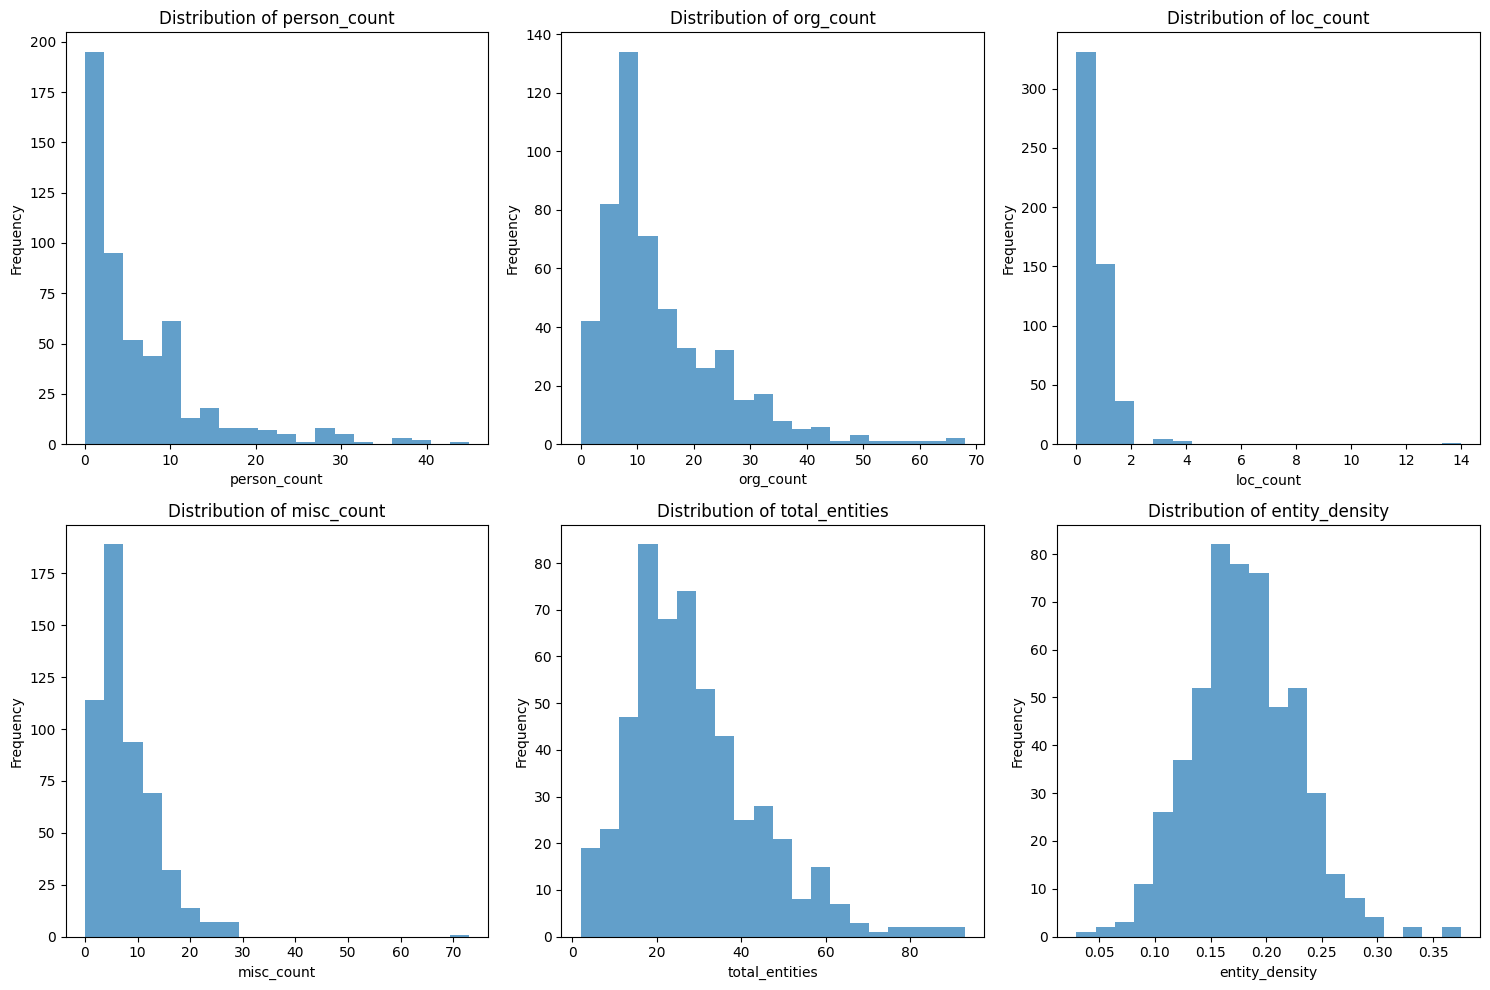

In [ ]:
print("=== SPLIT DATA ===")
X_text_train, X_text_test, X_ner_train, X_ner_test, y_train, y_test = train_test_split(
    X_text, X_ner, y, test_size=0.2, random_state=42, stratify=np.argmax(y, axis=1)
)

print(f"Training samples: {len(X_text_train)}")
print(f"Testing samples: {len(X_text_test)}")
print(f"Training labels distribution: {np.sum(y_train, axis=0)}")
print(f"Testing labels distribution: {np.sum(y_test, axis=0)}")

# Analisis fitur NER
print("\n=== ANALISIS FITUR NER ===")
ner_feature_names = ['person_count', 'org_count', 'loc_count', 'misc_count', 'total_entities', 'entity_density']
ner_stats = pd.DataFrame(X_ner_train, columns=ner_feature_names).describe()
print(ner_stats)

# Visualisasi distribusi fitur NER
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, feature in enumerate(ner_feature_names):
    axes[i].hist(X_ner_train[:, i], bins=20, alpha=0.7)
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
print("=== TRAINING MODEL ===")

# Parameter training (bisa disesuaikan)
EPOCHS = 10
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2

print(f"Training parameters:")
print(f"- Epochs: {EPOCHS}")
print(f"- Batch size: {BATCH_SIZE}")
print(f"- Validation split: {VALIDATION_SPLIT}")

# Mulai training
history = classifier.train(
    X_text_train, X_ner_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=VALIDATION_SPLIT
)

print("✓ Training completed!")

=== TRAINING MODEL ===
Training parameters:
- Epochs: 10
- Batch size: 32
- Validation split: 0.2
Memulai training...
Membangun model hybrid LSTM + NER...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model architecture:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 500)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ner_input           │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 500, 128)  │  1,280,000 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │        224 │ ner_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 128)       │     98,816 │ embedding[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 160)       │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     20,608 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 2)         │        130 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,408,034 (5.37 MB)

 Trainable params: 1,408,034 (5.37 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.4886 - loss: 1.8358 - precision: 0.4886 - recall: 0.4886 - val_accuracy: 0.6792 - val_loss: 0.6655 - val_precision: 0.6792 - val_recall: 0.6792
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.5503 - loss: 1.2186 - precision: 0.5503 - recall: 0.5503 - val_accuracy: 0.7736 - val_loss: 0.5781 - val_precision: 0.7736 - val_recall: 0.7736
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.6173 - loss: 0.9593 - precision: 0.6173 - recall: 0.6173 - val_accuracy: 0.8491 - val_loss: 0.4839 - val_precision: 0.8491 - val_recall: 0.8491
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.6657 - loss: 0.8561 - precision: 0.6657 - recall: 0.6657 - val_accuracy: 0.8491 - val_loss: 0.3002 - val_precision: 0.8491 - val_recall: 0.8491
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8520 - loss: 0.3896 - precision: 0.8520 - recall: 0.8520 - val_accuracy: 0.8868 - val_loss: 0.3086 - val

=== VISUALISASI TRAINING HISTORY ===


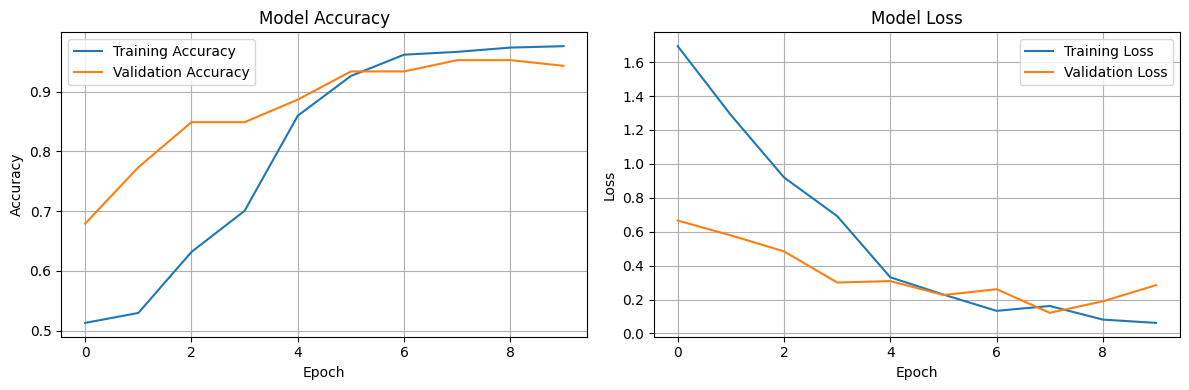


Final Training Accuracy: 0.9762
Final Validation Accuracy: 0.9434
Final Training Loss: 0.0621
Final Validation Loss: 0.2847


In [ ]:
print("=== VISUALISASI TRAINING HISTORY ===")

# Plot training & validation accuracy and loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Accuracy plot
ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Loss plot
ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Print final metrics
final_epoch = len(history.history['accuracy']) - 1
print(f"\nFinal Training Accuracy: {history.history['accuracy'][final_epoch]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][final_epoch]:.4f}")
print(f"Final Training Loss: {history.history['loss'][final_epoch]:.4f}")
print(f"Final Validation Loss: {history.history['val_loss'][final_epoch]:.4f}")

=== EVALUASI MODEL PADA TEST SET ===
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 416ms/step
Accuracy: 0.9621

Classification Report:
              precision    recall  f1-score   support

        hoax       0.98      0.92      0.95        49
    non-hoax       0.95      0.99      0.97        83

    accuracy                           0.96       132
   macro avg       0.97      0.95      0.96       132
weighted avg       0.96      0.96      0.96       132



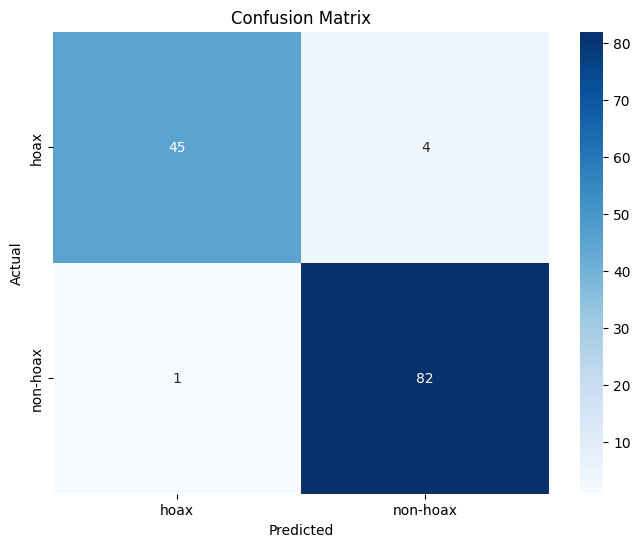


=== RINGKASAN EVALUASI ===
Test Accuracy: 0.9621


In [ ]:
print("=== EVALUASI MODEL PADA TEST SET ===")

accuracy, report = classifier.evaluate_model(X_text_test, X_ner_test, y_test)

print(f"\n=== RINGKASAN EVALUASI ===")
print(f"Test Accuracy: {accuracy:.4f}")

In [ ]:
print("=== TEST PREDIKSI MANUAL ===")

# Contoh teks untuk testing (bisa diganti dengan teks lain)
test_texts = [
    "Beredar sebuah unggahan video di media sosial Facebook yang memperlihatkan Presiden Federation Internationale de Football Association (FIFA) Gianni Infantino sedang berpidato. Video tersebut diklaim sebagai pernyataan resmi FIFA untuk kemenangan Tim Nasional (Timnas) Indonesia saat melawan Bahrain dalam putaran ketiga Kualifikasi Piala Dunia 2026 Zona Asia pada Kamis, 10 Oktober 2024. "
]

# --- Validasi apakah teks mengandung informasi tentang timnas ---
kata_kunci_timnas = [
    'timnas', 'indonesia', 'u-23', 'u23', 'u-20', 'tim nasional',
    'garuda', 'piala', 'aff', 'asia', 'kualifikasi', 'fifa', 'laga', 'pertandingan',
    'skuad', 'pssi', 'pelatih', 'shin', 'erick', 'thohir', 'klasemen',
    'stadion', 'gol', 'melawan', 'kemenangan', 'klasemen', 'grup', 'zona',
    'lolos', 'babak', 'final', 'semi-final', 'penyerang', 'bek', 'kiper', 'line-up',
    'elkan', 'egy', 'asnawi', 'marselino', 'rizky ridho', 'pratama', 'rafli', 'ernando'
]

def relevan_dengan_timnas(teks_input):
    teks_lower = teks_input.lower()
    return any(kata in teks_lower for kata in kata_kunci_timnas)

# Filter teks yang relevan
teks_terfilter = [t for t in test_texts if relevan_dengan_timnas(t)]

if not teks_terfilter:
    print("Tolong up berita yang berkaitan tentang timnas")
else:
    predictions, confidence = classifier.predict(teks_terfilter)

    print("Hasil Prediksi:")
    print("=" * 80)

    for i, (text, pred, conf) in enumerate(zip(teks_terfilter, predictions, confidence)):
        print(f"\nTeks {i+1}:")
        print(f"Content: {text[:100]}{'...' if len(text) > 100 else ''}")
        print(f"Prediksi: {pred}")
        print(f"Confidence: {conf:.3f}")
        print("-" * 50)


=== TEST PREDIKSI MANUAL ===


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
Hasil Prediksi:

Teks 1:
Content: Beredar sebuah unggahan video di media sosial Facebook yang memperlihatkan Presiden Federation Inter...
Prediksi: hoax
Confidence: 0.757
--------------------------------------------------


In [ ]:
# Menyimpan model ke dalam file .h5
classifier.model.save("model_ner_lstm.h5")
print("Model berhasil disimpan sebagai model_ner_lstm.h5")

Model berhasil disimpan sebagai model_ner_lstm.h5


In [ ]:
import tensorflow as tf

# Ganti dengan nama file .h5 Anda
model = tf.keras.models.load_model('model_ner_lstm.h5')

In [ ]:
# Simpan dengan nama baru dalam format .keras
model.save('model_final.keras')

In [ ]:
# Asumsikan 'classifier' adalah nama objek dari kelas HoaxClassifier Anda
import json

tokenizer_json = classifier.tokenizer.to_json()
with open('tokenizer.json', 'w', encoding='utf-8') as f:
    # ensure_ascii=False penting untuk bahasa Indonesia
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

# Setelah ini, unduh file tokenizer.json dari Colab